# `ROIC-Analysis_ver3.ipynb`


In [2]:
%load_ext autoreload
%autoreload 2
import logging
import os
import sqlite3
import sys
import warnings
from pathlib import Path

import pandas as pd
import plotly.graph_objects as go
from dotenv import load_dotenv

# ルートロガーのレベルをWARNINGに設定
# これにより、INFOレベルのメッセージはすべて抑制されます
logging.basicConfig(level=logging.WARNING)
# warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings("ignore")
load_dotenv()

UNIVERSE_CODE = "MSXJPN_AD"

QUANTS_DIR = Path(os.environ.get("QUANTS_DIR"))  # type: ignore
FACTSET_ROOT_DIR = Path(os.environ.get("FACTSET_ROOT_DIR"))  # type: ignore
FACTSET_FINANCIALS_DIR = Path(os.environ.get("FACTSET_FINANCIALS_DIR"))  # type: ignore
FACTSET_INDEX_CONSTITUENTS_DIR = Path(os.environ.get("FACTSET_INDEX_CONSTITUENTS_DIR"))  # type: ignore
INDEX_DIR = FACTSET_FINANCIALS_DIR / UNIVERSE_CODE
BPM_ROOT_DIR = Path(os.environ.get("BPM_ROOT_DIR"))  # type: ignore
BLOOMBERG_ROOT_DIR = Path(os.environ.get("BLOOMBERG_ROOT_DIR"))  # type: ignore
BLOOMBERG_DATA_DIR = Path(os.environ.get("BLOOMBERG_DATA_DIR"))  # type: ignore

sys.path.insert(0, str(QUANTS_DIR))
import src.database_utils as db_utils
import src.ROIC_make_data_files_ver2 as roic_utils
from src.roic_analysis import PerformanceAnalyzer

financials_db_path = INDEX_DIR / "Financials_and_Price.db"
factset_index_db_path = FACTSET_INDEX_CONSTITUENTS_DIR / "Index_Constituents.db"
bloomberg_index_db_path = BLOOMBERG_ROOT_DIR / "Index_Price_and_Returns.db"
bloomberg_valuation_db_path = BLOOMBERG_ROOT_DIR / "Valuation.db"
bpm_db_path = BPM_ROOT_DIR / "Index_Constituents.db"


# Alpha Sector / Non-alpha Sector
alpha_sectors = [
    "Information Technology",
    "Communication Services",
    "Health Care",
    "Industrials",
    "Materials",
    "Consumer Staples",
    "Consumer Discretionary",
    "Financials",
]
non_alpha_sectors = ["Energy", "Utilities", "Real Estate"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis plan

### 1. 2025 年（直近）の loser 特定

-   ROIC が低下した銘柄群

    -   ROIC 分位を移動した銘柄でラベリング（3 年前 ROIC 分位 -> 現在 ROIC 分位 でラベリング）

        -   ラベルごとの銘柄数をカウントする必要あり

### 2. ROIC dispersion の計測

-   計測済み

### 3. ヒストリカルのグロース性が高かった銘柄

-   長期期間と直近のパフォーマンス比較

    -   期待リターンと効率性計測

    -   active return 計測

    -   IC 計測


## 1. 2025 年（直近）の loser 特定

-   ROIC が低下した銘柄群

    -   ROIC 分位を移動した銘柄でラベリング（3 年前 ROIC 分位 -> 現在 ROIC 分位 でラベリング）

        -   ラベルごとの銘柄数をカウントする必要あり


In [ ]:
analyzer = PerformanceAnalyzer(
    factset_index_db_path=factset_index_db_path,
    financials_db_path=financials_db_path,
    UNIVERSE_CODE=UNIVERSE_CODE,
)
df = analyzer.data_loader()

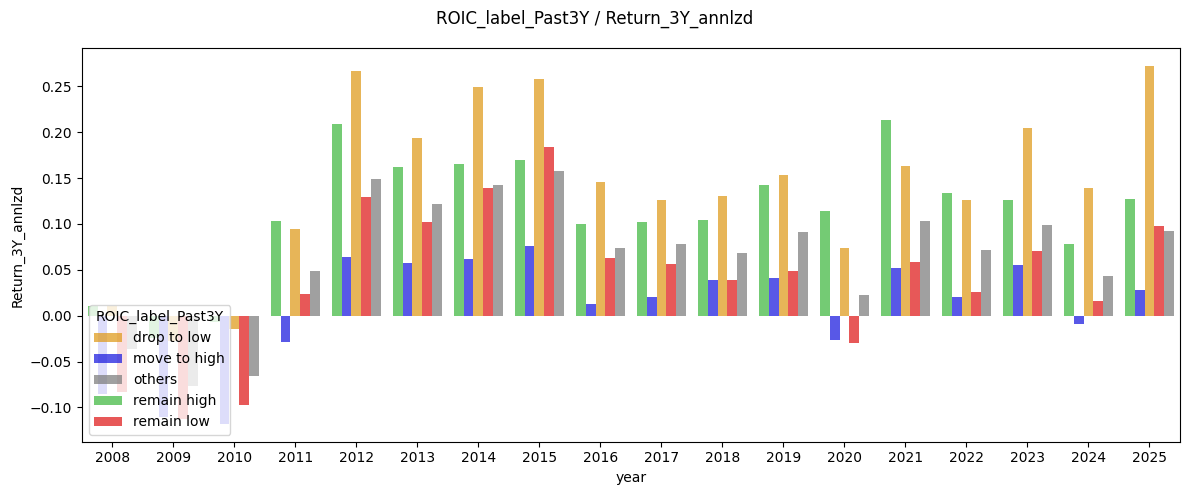

In [ ]:
# ROIC_label_Past3Y のperformance
roic_factor_name = "ROIC_label_Past3Y"
return_col = "Return_3Y_annlzd"
df_to_plot = analyzer.calculate_mean_returns_for_roic_label(
    df=df, factor_col=roic_factor_name, return_col=return_col
)
analyzer.plot_roic_label_performance(
    df_to_plot=df_to_plot, roic_factor_name=roic_factor_name, return_col=return_col
)

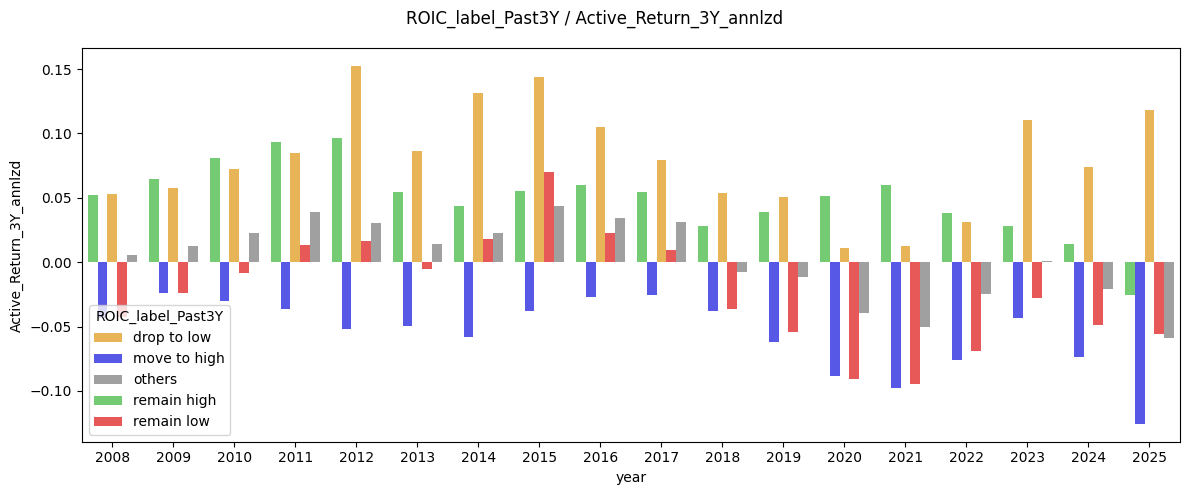

In [ ]:
# ROIC_label_Past5Y のperformance
roic_factor_name = "ROIC_label_Past3Y"
return_col = "Active_Return_3Y_annlzd"
df_to_plot = analyzer.calculate_mean_returns_for_roic_label(
    df=df, factor_col=roic_factor_name, return_col=return_col
)
analyzer.plot_roic_label_performance(
    df_to_plot=df_to_plot, roic_factor_name=roic_factor_name, return_col=return_col
)

Alpha Sectors
Non-Alpha Sectors


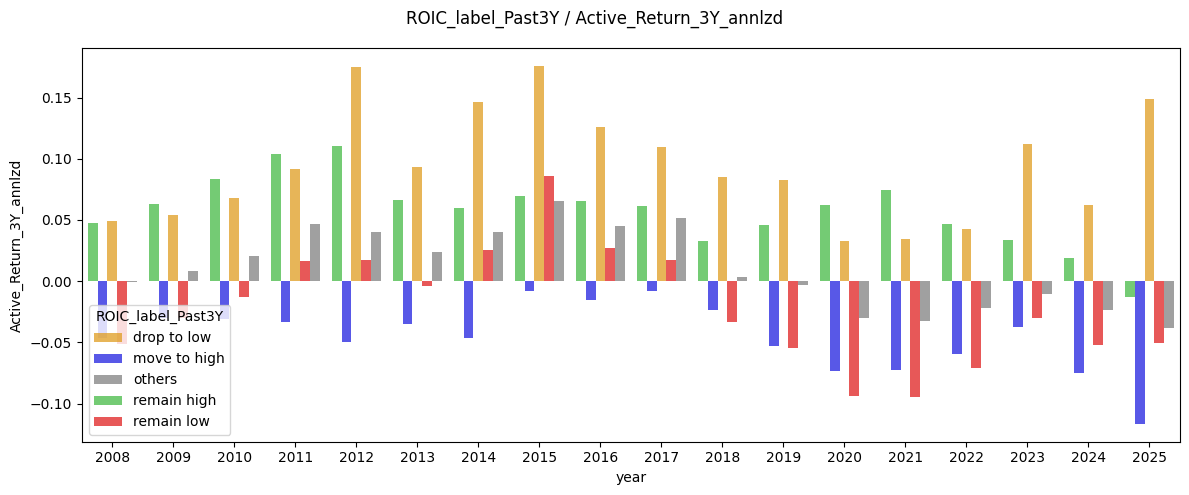

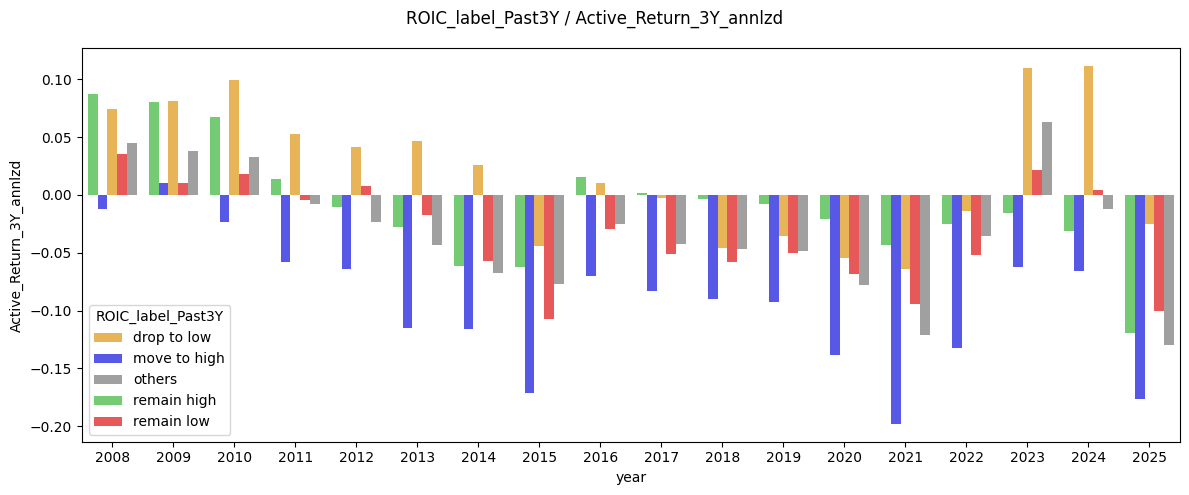

In [ ]:
# ROIC_label_Past5Y のperformance(for Alpha sectors)
roic_factor_name = "ROIC_label_Past3Y"
return_col = "Active_Return_3Y_annlzd"

print("Alpha Sectors")
df_alpha_sectors = df.loc[df["GICS Sector"].isin(alpha_sectors)].reset_index(drop=True)
df_performance = analyzer.calculate_mean_returns_for_roic_label(
    df_alpha_sectors, factor_col=roic_factor_name, return_col=return_col
)
analyzer.plot_roic_label_performance(
    df_to_plot=df_performance, roic_factor_name=roic_factor_name, return_col=return_col
)

print("Non-Alpha Sectors")
df_non_alpha_sectors = df.loc[df["GICS Sector"].isin(non_alpha_sectors)].reset_index(
    drop=True
)
df_performance = analyzer.calculate_mean_returns_for_roic_label(
    df_non_alpha_sectors, factor_col=roic_factor_name, return_col=return_col
)
analyzer.plot_roic_label_performance(
    df_to_plot=df_performance, roic_factor_name=roic_factor_name, return_col=return_col
)

### α セクターのうち、remian high と drop to low のパフォーマンス（2025）


In [ ]:
def display_performance_table(df_target: pd.DataFrame):
    count_by_sector = pd.DataFrame(
        df_target.groupby(["GICS Sector"])["P_SYMBOL"].count().sort_values()
    )
    display(count_by_sector)

    return_mean_col = f"{return_col}_mean"
    return_std_col = f"{return_col}_std"
    efficiency_col = "Efficiency"

    eff_by_sector = (
        # 1. GICS Sectorでグループ化
        df_target.groupby(["GICS Sector"])  # type: ignore
        # 2. aggを使用して、平均(mean)と標準偏差(std)を同時に計算
        .agg(
            {  # type:ignore
                return_col: [
                    (return_mean_col, roic_utils.clipped_mean),
                    (return_std_col, roic_utils.clipped_std),
                ]
            }
        )
        .droplevel(0, axis=1)
        # 3. リターンを標準偏差で割ってEfficiencyを計算し、カラムを追加
        .assign(**{efficiency_col: lambda x: x[return_mean_col].div(x[return_std_col])})
        # 4. Efficiencyでソート
        .sort_values(by=efficiency_col, ascending=True)
    )
    display(eff_by_sector)


alpha_sector_and_remain_high = df_alpha_sectors.loc[
    (df_alpha_sectors["ROIC_label_Past3Y"] == "remain high")
    & (df_alpha_sectors["year"] == 2025)
]
alpha_sector_and_drop_to_low = df_alpha_sectors.loc[
    (df_alpha_sectors["ROIC_label_Past3Y"] == "drop to low")
    & (df_alpha_sectors["year"] == 2025)
]


pd.options.display.precision = 3
print("===== remain high =====")
display_performance_table(alpha_sector_and_remain_high)
print("===== drop to low =====")
display_performance_table(alpha_sector_and_drop_to_low)

===== remain high =====


,P_SYMBOL
GICS Sector,
Materials,124
Communication Services,132
Consumer Staples,193
Information Technology,275
Health Care,278
Consumer Discretionary,297
Financials,344
Industrials,434


,Active_Return_3Y_annlzd_mean,Active_Return_3Y_annlzd_std,Efficiency
GICS Sector,,,
Materials,-0.128,0.094,-1.358
Consumer Staples,-0.127,0.130,-0.975
Health Care,-0.099,0.162,-0.610
Industrials,-0.008,0.158,-0.054
Communication Services,-0.003,0.207,-0.016
Financials,0.045,0.177,0.252
Consumer Discretionary,0.056,0.181,0.310
Information Technology,0.089,0.257,0.346


===== drop to low =====


,P_SYMBOL
GICS Sector,
Communication Services,55
Consumer Discretionary,103
Information Technology,125
Consumer Staples,126
Health Care,133
Materials,187
Industrials,192
Financials,307


,Active_Return_3Y_annlzd_mean,Active_Return_3Y_annlzd_std,Efficiency
GICS Sector,,,
Consumer Staples,-0.055,0.118,-0.468
Health Care,-0.045,0.202,-0.221
Communication Services,-0.007,0.167,-0.041
Consumer Discretionary,0.076,0.319,0.239
Materials,0.074,0.289,0.256
Information Technology,0.721,1.584,0.455
Financials,0.185,0.309,0.599
Industrials,0.446,0.599,0.744


-   remain high はベンチマーク負けが目立つ


## 2. ROIC Dispersion の計測

-   第一分位の ROIC 中央値が他の分位の ROIC の中央値の何倍かを見る

-   Financials は ROE、それ以外のアルファファクターは ROIC


In [ ]:
def calculate_factor_dispersion(
    df: pd.DataFrame, factor_name: str, sector_name: str
) -> pd.DataFrame:
    median_factor = (
        df.loc[df["GICS Sector"] == sector_name]
        .groupby(["date", f"{factor_name}_Rank"])[factor_name]
        .agg("median")
        .to_frame()
        .reset_index()
        .pivot(index="date", columns=f"{factor_name}_Rank", values=factor_name)
        .rename(columns={factor_name: f"{factor_name}_Rank_median"})
    ).assign(
        Dispersion_Q1_Q2=lambda x: x["rank1"].div(x["rank2"]),
        Dispersion_Q1_Q3=lambda x: x["rank1"].div(x["rank3"]),
        Dispersion_Q1_Q4=lambda x: x["rank1"].div(x["rank4"]),
    )

    return median_factor


def plot_dispersion(median_factor: pd.DataFrame, factor_name: str, sector_name: str):
    fig = go.Figure()
    for col in ["Dispersion_Q1_Q2", "Dispersion_Q1_Q3", "Dispersion_Q1_Q4"]:
        fig.add_trace(
            go.Scatter(
                x=median_factor.index,
                y=median_factor[col],
                mode="lines",
                name=col,
                line=dict(width=0.5),
            )
        )
    fig.update_layout(
        title=f"{factor_name} Dispersion ({sector_name})",
        yaxis_title="dispersion",
        hovermode="x",
        width=1000,
        height=300,
        template="plotly_dark",
        legend=dict(yanchor="top", y=-0.1, xanchor="center", x=0.5, orientation="h"),
        margin=dict(l=30, r=30, t=50, b=40),
    )
    fig.show()

In [ ]:
pd.options.display.precision = 2
# ROIC dispersion

for sector_name in [
    "Information Technology",
    "Communication Services",
    "Health Care",
    "Industrials",
    "Materials",
    "Consumer Staples",
    "Consumer Discretionary",
]:
    median_roic = calculate_factor_dispersion(
        df=df, factor_name="FF_ROIC", sector_name=sector_name
    )
    plot_dispersion(
        median_factor=median_roic, factor_name="FF_ROIC", sector_name=sector_name
    )

# Financials
median_roe = calculate_factor_dispersion(
    df=df, factor_name="FF_ROE", sector_name="Financials"
)
plot_dispersion(
    median_factor=median_roe, factor_name="FF_ROE", sector_name="Financials"
)

## 3. ヒストリカルのグロース性が高かった銘柄


In [ ]:
analyzer = PerformanceAnalyzer()
df = analyzer.data_loader()

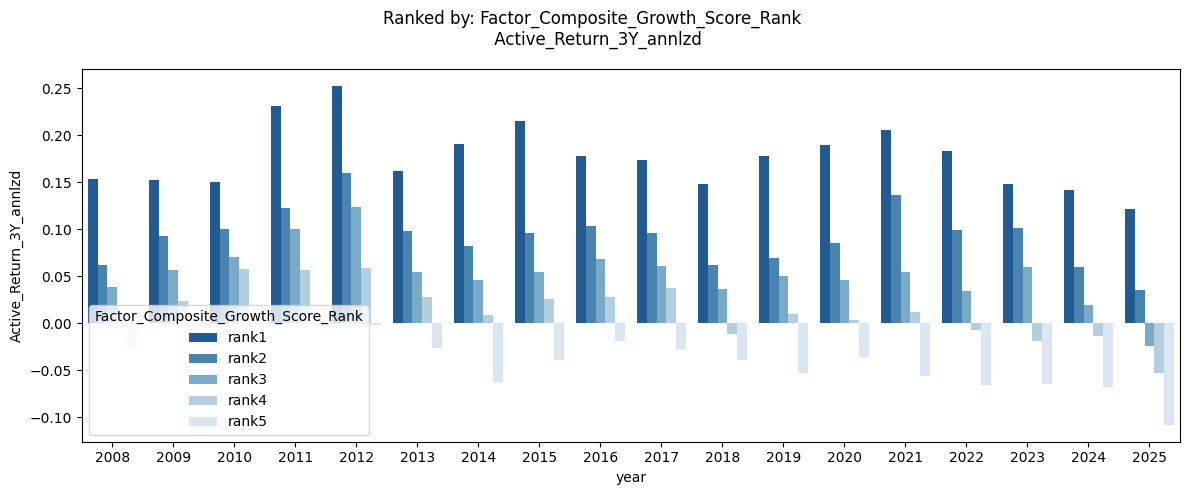

In [ ]:
# ROIC_label_Past3Y のperformance
# for alpha sectors
df_alpha_sectors = df.loc[df["GICS Sector"].isin(alpha_sectors)]

roic_factor_name = "ROIC_label_Past3Y"
factor_name = "Factor_Composite_Growth_Score_Rank"
return_col = "Active_Return_3Y_annlzd"

df_performance = analyzer.calculate_mean_returns_double_factors(
    df=df_alpha_sectors,
    factor1=roic_factor_name,
    factor2=factor_name,
    return_col=return_col,
    factor1_rank="remain high",
)

analyzer.plot_factor_performance(
    df_to_plot=df_performance, factor_name=factor_name, return_col=return_col
)

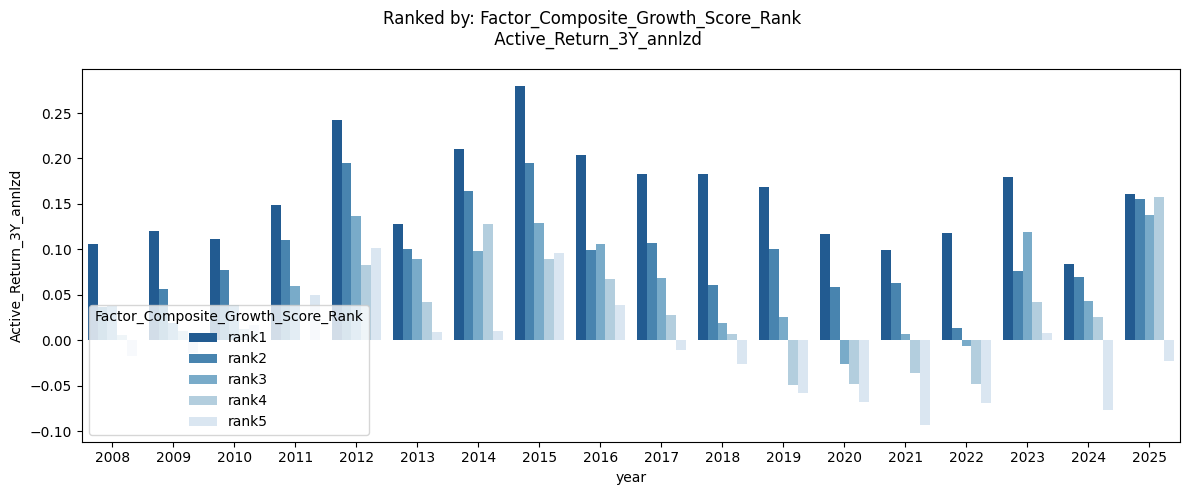

In [ ]:
# for alpha sectors
df_alpha_sectors = df.loc[df["GICS Sector"].isin(alpha_sectors)]

roic_factor_name = "ROIC_label_Past3Y"
factor_name = "Factor_Composite_Growth_Score_Rank"
return_col = "Active_Return_3Y_annlzd"

df_performance = analyzer.calculate_mean_returns_double_factors(
    df=df_alpha_sectors,
    factor1=roic_factor_name,
    factor2=factor_name,
    return_col=return_col,
    factor1_rank="drop to low",
)

analyzer.plot_factor_performance(
    df_to_plot=df_performance, factor_name=factor_name, return_col=return_col
)

### drop to low の財務スコア


In [ ]:
tables = db_utils.get_table_names(financials_db_path)
roic_factor_name = "ROIC_label_Past3Y"
factor_list = [s for s in tables if (s.startswith("FF_") and s.endswith("PctRank"))] + [
    roic_factor_name
]

# 抽出したい年 (2025年と2023年が混ざっていたが、エラーログに合わせて2023年に統一)
TARGET_YEAR = "2025"
# 繰り返し使用する SELECT * WHERE ... 部分
SELECT_PART = f"SELECT `date`, `P_SYMBOL`, `variable`, `value` FROM {{}} WHERE strftime('%Y', date) = '{TARGET_YEAR}'"
# UNION ALLで結合するための文字列を生成
union_all_clauses = [SELECT_PART.format(table) for table in factor_list]
# クエリ全体を結合
query = " \n    UNION ALL \n    ".join(union_all_clauses)

with sqlite3.connect(financials_db_path) as conn:
    df = pd.read_sql(query, con=conn, parse_dates=["date"])
df_factors = (
    df.loc[df["variable"] != roic_factor_name]
    .reset_index(drop=True)
    .pivot(index=["date", "P_SYMBOL"], columns="variable", values="value")
)
df_roic = (
    df.loc[df["variable"] == roic_factor_name]
    .reset_index(drop=True)
    .pivot(index=["date", "P_SYMBOL"], columns="variable", values="value")
)

df_final = pd.merge(
    df_factors, df_roic, left_index=True, right_index=True
).reset_index()
display(df_final)

variable,date,P_SYMBOL,FF_ASSETS_CAGR_3Y_PctRank,FF_ASSETS_CAGR_5Y_PctRank,FF_ASSETS_PctRank,FF_ASSETS_QoQ_PctRank,FF_ASSETS_YoY_PctRank,FF_BPS_PctRank,FF_BPS_TANG_PctRank,FF_CAPEX_CAGR_3Y_PctRank,...,FF_SALES_PctRank,FF_SALES_QoQ_PctRank,FF_SALES_YoY_PctRank,FF_SGA_PctRank,FF_SHLDRS_EQ_PctRank,FF_STK_OPT_EXP_PctRank,FF_STK_PURCH_CF_PctRank,FF_TAX_RATE_PctRank,FF_WKCAP_PctRank,ROIC_label_Past3Y
0,2025-01-31,1-HK,0.119617,0.067633,0.985915,0.352113,0.164319,0.464789,0.680751,0.075377,...,0.948357,0.723005,0.328638,0.923469,1.0,NaN,0.217391,0.975369,0.957746,remain low
1,2025-01-31,1038-HK,0.202899,0.089552,0.217391,0.217391,0.246377,0.231884,0.362319,NaN,...,0.028986,0.507246,0.101449,NaN,0.73913,NaN,NaN,1.0,0.608696,remain high
2,2025-01-31,11-HK,0.419048,0.285024,0.608491,0.953271,0.728972,0.245283,0.410377,0.210526,...,0.533019,0.78972,0.21028,NaN,0.580189,NaN,0.717277,0.156566,0.183962,others
3,2025-01-31,1113-HK,0.279412,0.268657,0.926471,0.661765,0.470588,0.441176,0.5,0.175439,...,0.970588,0.676471,0.558824,0.455882,0.970588,NaN,0.794118,0.686275,0.985294,others
4,2025-01-31,12-HK,0.382353,0.492537,0.941176,0.617647,0.455882,0.279412,0.323529,0.017544,...,0.867647,0.955882,0.058824,0.897059,0.955882,NaN,0.411765,0.921569,0.970588,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10477,2025-10-31,ZAL-DE,0.823529,0.597561,0.282353,0.990196,0.911765,0.470588,0.529412,0.13253,...,0.418605,0.882353,0.95098,0.614458,0.364706,0.508475,0.189024,0.986486,0.388235,remain low
10478,2025-10-31,ZBH-US,0.329897,0.125,0.534653,0.75,0.657407,0.78125,0.3125,0.597938,...,0.356436,0.046296,0.62037,0.469388,0.633663,NaN,0.20297,0.319149,0.727723,others
10479,2025-10-31,ZBRA-US,0.228916,0.481481,0.349398,0.646018,0.371681,0.8875,0.175,0.47561,...,0.416667,0.539823,0.283186,0.390244,0.39759,0.388158,0.432099,0.9125,0.439024,others
10480,2025-10-31,ZTS-US,0.371134,0.21875,0.415842,0.888889,0.518519,0.25,0.541667,0.278351,...,0.405941,0.064815,0.074074,0.387755,0.376238,0.26087,0.762376,0.425532,0.792079,remain high


In [ ]:
factors = [s for s in tables if (s.startswith("FF_") and s.endswith("PctRank"))]
g = df_final.groupby([roic_factor_name])[factors].agg(["mean", "median"])
display(g)

variable          FF_SALES_QoQ_PctRank           FF_SALES_CAGR_5Y_PctRank  \
                                  mean    median                     mean   
ROIC_label_Past3Y                                                           
drop to low                   0.524111  0.528037                 0.544025   
move to high                  0.487455  0.461538                 0.468371   
others                        0.504308  0.492823                 0.467357   
remain high                   0.509004   0.51835                  0.52901   
remain low                    0.492799  0.502416                 0.474848   

variable                    FF_SALES_CAGR_3Y_PctRank            \
                     median                     mean    median   
ROIC_label_Past3Y                                                
drop to low        0.559524                 0.614185  0.670051   
move to high       0.452175                 0.382753  0.314286   
others             0.458507                 0.471271  0.461538   
remain high        0.532338                 0.494315  0.495025   
remain low         0.446701                 0.541995  0.569767   

variable          FF_SALES_YoY_PctRank           FF_EBITDA_OPER_QoQ_PctRank  \
                                  mean    median                       mean   
ROIC_label_Past3Y                                                             
drop to low                     0.5612  0.581818                   0.530779   
move to high                  0.444936  0.438596                   0.494119   
others                        0.482891  0.476413                   0.511046   
remain high                   0.530766  0.544578                   0.510818   
remain low                    0.477879  0.454545                   0.487978   

variable                     ... FF_SHLDRS_EQ_PctRank            \
                     median  ...                 mean    median   
ROIC_label_Past3Y            ...                                  
drop to low        0.553823  ...             0.499767  0.512195   
move to high       0.466369  ...             0.535644  0.520408   
others             0.515625  ...             0.558661  0.575974   
remain high        0.520661  ...             0.427346  0.387682   
remain low         0.492537  ...             0.583188  0.602871   

variable          FF_STK_OPT_EXP_PctRank           FF_STK_PURCH_CF_PctRank  \
                                    mean    median                    mean   
ROIC_label_Past3Y                                                            
drop to low                      0.55464  0.564103                0.527665   
move to high                    0.469161  0.423077                0.482876   
others                          0.497581  0.486486                 0.51777   
remain high                     0.526164  0.538462                0.583979   
remain low                      0.533029  0.567366                0.431749   

variable                    FF_TAX_RATE_PctRank           FF_WKCAP_PctRank  \
                     median                mean    median             mean   
ROIC_label_Past3Y                                                            
drop to low             0.5             0.46742  0.471698         0.468478   
move to high       0.434259            0.535212  0.570707         0.547328   
others             0.487805            0.507138  0.509852         0.510846   
remain high        0.607843            0.478274  0.470588         0.527459   
remain low            0.375            0.557082  0.597561         0.462183   

variable                     
                     median  
ROIC_label_Past3Y            
drop to low         0.46694  
move to high       0.557692  
others             0.516353  
remain high        0.534884  
remain low         0.448113  

[5 rows x 316 columns]